In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pickle
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Parameters
learning_rates = [0.001, 0.0001, 0.00001]
epochs = 200
patience = 20

# Directory Google Drive for results
drive_path = '/content/drive/MyDrive/Colab Notebooks/MLP_Lr'

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15885769.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 477440.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4407494.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4382454.28it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 28)
        self.fc2 = nn.Linear(28 * 28, 256)
        self.fc3 = nn.Linear(256, 10)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Training and validation
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses, best_val_loss

In [7]:
def save_results(results, filename):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

def load_results(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [8]:
for lr in learning_rates:
    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(f'Training with learning rate: {lr}')
    train_losses, val_losses, best_val_loss = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs, patience)

    results = {
        'learning_rate': lr,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss
    }

    save_results(results, os.path.join(drive_path, f'results_lr_{lr}.pkl'))

Training with learning rate: 0.001
Epoch 1/200, Train Loss: 0.2905, Validation Loss: 0.1519
Epoch 2/200, Train Loss: 0.1340, Validation Loss: 0.1204
Epoch 3/200, Train Loss: 0.0985, Validation Loss: 0.0965
Epoch 4/200, Train Loss: 0.0819, Validation Loss: 0.0941
Epoch 5/200, Train Loss: 0.0676, Validation Loss: 0.1025
Epoch 6/200, Train Loss: 0.0582, Validation Loss: 0.0907
Epoch 7/200, Train Loss: 0.0559, Validation Loss: 0.0777
Epoch 8/200, Train Loss: 0.0433, Validation Loss: 0.0776
Epoch 9/200, Train Loss: 0.0427, Validation Loss: 0.0779
Epoch 10/200, Train Loss: 0.0402, Validation Loss: 0.0840
Epoch 11/200, Train Loss: 0.0318, Validation Loss: 0.0833
Epoch 12/200, Train Loss: 0.0362, Validation Loss: 0.0880
Epoch 13/200, Train Loss: 0.0315, Validation Loss: 0.0826
Epoch 14/200, Train Loss: 0.0270, Validation Loss: 0.0916
Epoch 15/200, Train Loss: 0.0272, Validation Loss: 0.0966
Epoch 16/200, Train Loss: 0.0269, Validation Loss: 0.0961
Epoch 17/200, Train Loss: 0.0244, Validation L

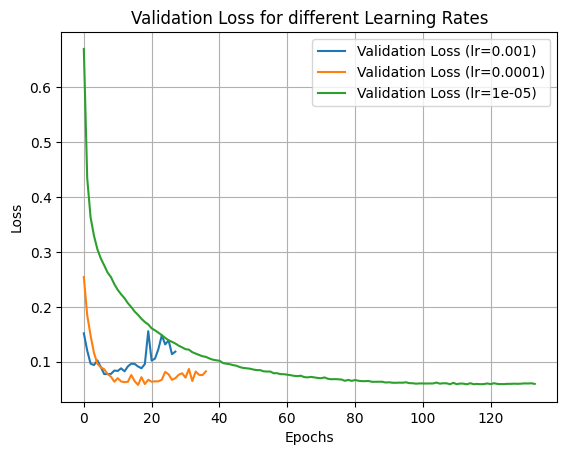

In [9]:
for lr in learning_rates:
    results = load_results(os.path.join(drive_path, f'results_lr_{lr}.pkl'))
    plt.plot(range(len(results['val_losses'])), results['val_losses'], label=f'Validation Loss (lr={lr})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss for different Learning Rates')
plt.grid(True)
plt.show()
